In [1]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns

In [2]:
def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None, phi_in_radians=False):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation_plus_major_axis(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['major_ax'])
            height = int(current_frame_data['minor_ax'])
            phi = np.deg2rad(float(current_frame_data['phi']))  # Convert angle to radians
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Calculate endpoints of major axis
            axis_length = max(width, height) / 2
            sin_phi = np.sin(phi)
            cos_phi = np.cos(phi)
            x1 = int(center_x + axis_length * cos_phi)
            y1 = int(center_y + axis_length * sin_phi)
            x2 = int(center_x - axis_length * cos_phi)
            y2 = int(center_y - axis_length * sin_phi)
            
            # Draw major axis
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {np.rad2deg(phi)}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [3]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = [7]
bad_blocks = [] #
experiment_path = pathlib.Path(r"z:\Nimrod\experiments")
animal = 'PV_126'

block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 007 at Path: z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!


In [4]:
block = block_collection[0]

In [5]:
block.block_get_lizard_movement()
#block.block_get_lizard_movement()

path to mat file is z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\Animal=PV_126,recNames=block_007\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


In [7]:
# over here, perform a rolling window analysis and select threshold for active/quite segmentation
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
def rolling_window_analysis(df, window_size=10000, step_size=1000):
    """
    Perform a rolling window analysis on the movAll column of the input dataframe.

    Args:
        df (pd.DataFrame): Input dataframe with 't_mov_ms' (timestamps in ms) and 'movAll' (magnitudes).
        window_size (int): Size of the rolling window in milliseconds (default 10,000 ms).
        step_size (int): Step size for the rolling window in milliseconds (default 1,000 ms).

    Returns:
        pd.DataFrame: A dataframe containing the start time of each window and the average movAll value.
    """
    # Ensure the dataframe is sorted by time
    df = df.sort_values('t_mov_ms').reset_index(drop=True)
    
    # Get the range of timestamps
    t_min = df['t_mov_ms'].min()
    t_max = df['t_mov_ms'].max()
    
    # Create the rolling window start times
    window_starts = np.arange(t_min, t_max + step_size, step_size)
    
    # Initialize results
    results = {'window_start': [], 'average_movAll': []}
    
    for start in window_starts:
        # Define the window range
        end = start + window_size
        # Filter events within the window
        window_data = df[(df['t_mov_ms'] >= start) & (df['t_mov_ms'] < end)]
        # Compute the average movAll or set to 0 if no events occurred
        avg_movAll = window_data['movAll'].mean() if not window_data.empty else 0
        # Append results
        results['window_start'].append(start)
        results['average_movAll'].append(avg_movAll)
    
    # Return the results as a dataframe
    return pd.DataFrame(results)

df =  rolling_window_analysis(block.liz_mov_df,10000,1000)
# Initialize Plotly figure
fig = go.Figure()

# Add the movement trace
fig.add_trace(go.Scatter(
    x=df['window_start'],
    y=df['average_movAll'],
    mode='lines+markers',
    name='Average Movement',
    line=dict(color='blue')
))

# Add an initial threshold line
initial_threshold = 0.5
fig.add_trace(go.Scatter(
    x=df['window_start'],
    y=[initial_threshold] * len(df),
    mode='lines',
    name='Threshold',
    line=dict(color='red', dash='dash')
))

# Update layout for interactivity
fig.update_layout(
    title="Interactive Movement Threshold Selection",
    xaxis_title="Time (ms)",
    yaxis_title="Average Movement",
    sliders=[{
        "active": 5,
        "currentvalue": {"prefix": "Threshold: "},
        "steps": [
            {"label": str(round(threshold, 2)), "method": "update", 
             "args": [{"y": [df['average_movAll'], [threshold] * len(df)]}]}
            for threshold in [x / 10.0 for x in range(0, 20)]
        ]
    }]
)

# Show the interactive plot
fig.show()

In [163]:
block

BlockSync object for animal PV_143 with 
block_num 004 at date PV143_ET_d1t4_2025-08-11_14-58-28

In [8]:
threshold = 0.001
df['behavior'] = df['average_movAll'].apply(lambda x: 'active' if x > threshold else 'quiet')
def create_behavior_df(df):
    """
    Transform the annotated dataframe into a compact behavioral dataframe.
    
    Args:
        df (pd.DataFrame): Dataframe with 'window_start' and 'behavior' columns.

    Returns:
        pd.DataFrame: Compact behavioral dataframe with 'start_time', 'end_time', and 'annotation'.
    """
    # Initialize variables
    behavior_df = []
    current_behavior = df['behavior'].iloc[0]
    start_time = df['window_start'].iloc[0]

    for i in range(1, len(df)):
        # If the behavior changes, mark the end of the current behavioral window
        if df['behavior'].iloc[i] != current_behavior:
            end_time = df['window_start'].iloc[i]  # End time is the start of the next window
            behavior_df.append({
                'start_time': start_time,
                'end_time': end_time,
                'annotation': current_behavior
            })
            # Start a new behavioral window
            current_behavior = df['behavior'].iloc[i]
            start_time = df['window_start'].iloc[i]
    
    # Append the last behavioral window
    end_time = df['window_start'].iloc[-1] + 1000  # Include the last second
    behavior_df.append({
        'start_time': start_time,
        'end_time': end_time,
        'annotation': current_behavior
    })
    
    # Convert to a dataframe
    return pd.DataFrame(behavior_df)

# Apply to your dataframe
behavior_df = create_behavior_df(df)
print(behavior_df)



    start_time   end_time annotation
0          4.0   316004.0      quiet
1     316004.0   338004.0     active
2     338004.0   372004.0      quiet
3     372004.0   383004.0     active
4     383004.0   415004.0      quiet
5     415004.0   417004.0     active
6     417004.0   430004.0      quiet
7     430004.0   459004.0     active
8     459004.0   479004.0      quiet
9     479004.0   485004.0     active
10    485004.0   569004.0      quiet
11    569004.0   578004.0     active
12    578004.0   617004.0      quiet
13    617004.0   628004.0     active
14    628004.0   645004.0      quiet
15    645004.0   647004.0     active
16    647004.0   744004.0      quiet
17    744004.0   754004.0     active
18    754004.0   838004.0      quiet
19    838004.0   841004.0     active
20    841004.0   853004.0      quiet
21    853004.0   863004.0     active
22    863004.0   921004.0      quiet
23    921004.0   930004.0     active
24    930004.0   987004.0      quiet
25    987004.0  1003004.0     active
2

In [165]:
block.behavior_state = behavior_df
csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
behavior_df.to_csv(csv_path, index=False)
print(f"Behavior state saved to {csv_path}")

Behavior state saved to z:\Nimrod\experiments\PV_143\2025_08_25\block_004\analysis\block_004_behavior_state.csv


In [166]:
block.calibrate_pixel_size(10)
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')

load_eye_data_2d_w_rotation_matrix(block)


got the calibration values from the analysis folder


In [167]:

block.left_eye_data['pupil_diameter']= block.left_eye_data['major_ax'] * block.L_pix_size
block.right_eye_data['pupil_diameter']= block.right_eye_data['major_ax'] * block.R_pix_size

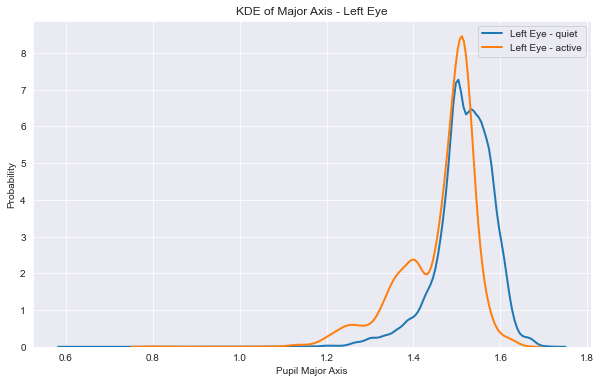

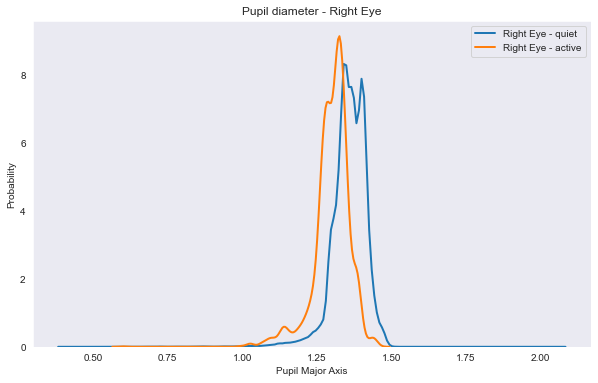

In [168]:
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create a dictionary to store major_ax values for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period in behavior_df
    for i, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get left and right eye major_ax values for the corresponding time windows
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        # Append these values to the corresponding annotation label
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye with normalization and thicker lines
    plt.figure(figsize=(10, 6))
    for annotation in left_eye_aggregated.keys():
        sns.kdeplot(left_eye_aggregated[annotation], label=f'Left Eye - {annotation}', fill=False, common_norm=False, linewidth=2)
    plt.title('KDE of Major Axis - Left Eye')
    plt.xlabel('Pupil Major Axis')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')
    #plt.ylim(0, 1)
    
    # If export_path is provided, save to PDF
    if export_path is not None:
        pdf_pages.savefig()  # Save the current figure to the PDF
    plt.show()

    # Plot KDE for the right eye with normalization and thicker lines
    plt.figure(figsize=(10, 6))
    for annotation in right_eye_aggregated.keys():
        sns.kdeplot(right_eye_aggregated[annotation], label=f'Right Eye - {annotation}', fill=False, common_norm=False, linewidth=2)
    plt.title('Pupil diameter - Right Eye')
    plt.xlabel('Pupil Major Axis')
    plt.ylabel('Probability')
    #plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.grid(False)
    
    # If export_path is provided, save to PDF
    if export_path is not None:
        pdf_pages.savefig()  # Save the current figure to the PDF
        pdf_pages.close()  # Close the PDF after saving both figures

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_kde_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None)

